## Import

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

## Download

In [4]:
# Fetch DAX data
ticker_symbol = "^GDAXI"
dax_data = yf.download(ticker_symbol, start="1900-01-01", end="2025-04-09")

# Convert to a Pandas DataFrame
dax_df = pd.DataFrame(dax_data)


[*********************100%***********************]  1 of 1 completed


In [5]:
# Display the cleaned DataFrame
dax_df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GDAXI,^GDAXI,^GDAXI,^GDAXI,^GDAXI
Date,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,0
1988-01-04,956.489990,956.489990,956.489990,956.489990,0
1988-01-05,996.099976,996.099976,996.099976,996.099976,0
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,0
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,0


## Cleaning

In [12]:
# Ensure the index is reset and avoid duplicate columns
if dax_df.index.name == 'Date':
    dax_df = dax_df.reset_index()

# Flatten the multi-level columns
dax_df.columns = ['Date' if col == 'Date' else col[0] if isinstance(col, tuple) else col for col in dax_df.columns]

# Rename the 'Close' column to 'points'
dax_df = dax_df.rename(columns={'Close': 'Points'})[['Date', 'Points']]

# Display the cleaned DataFrame
dax_df.head()

,Date,Points
0,1987-12-30,1005.190002
1,1988-01-04,956.489990
2,1988-01-05,996.099976
3,1988-01-06,1006.010010
4,1988-01-07,1014.469971


## Crash Periods

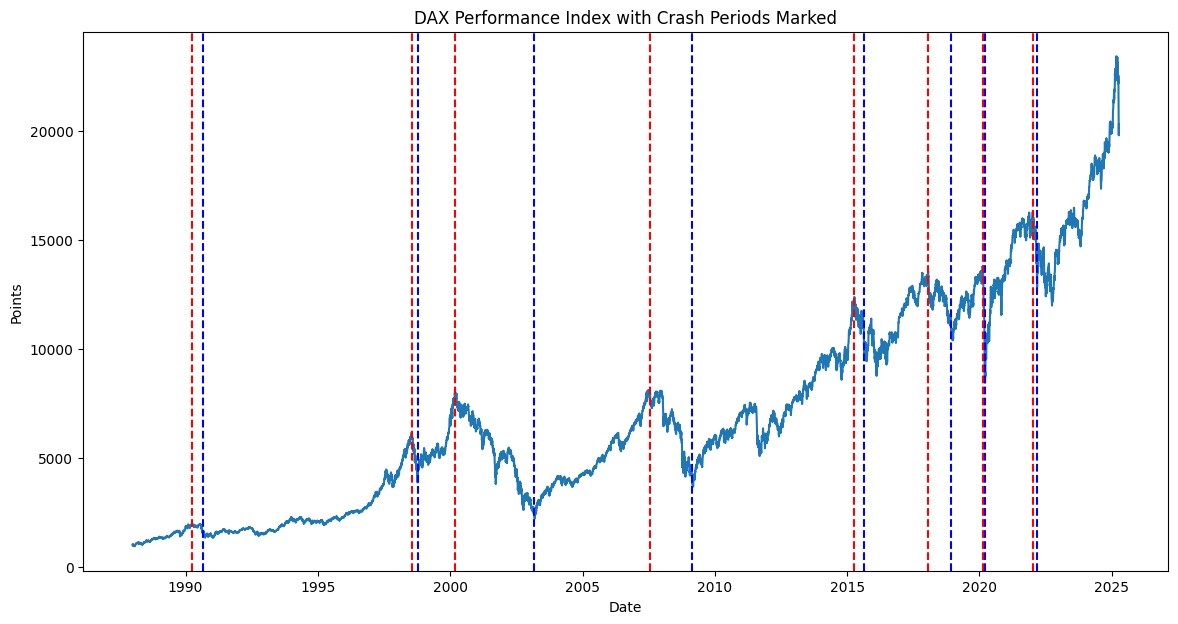

In [14]:
# Convert Date column to datetime if not already done
dax_df['Date'] = pd.to_datetime(dax_df['Date'])

# Create a new column to track crash start and end events
dax_df['Crash_Event'] = None

# Identify crash periods where the dax fell more than 20%
all_time_peak = dax_df['Points'][0]
peak = dax_df['Points'][0]
peak_date = dax_df['Date'][0]
last_event = 'end'

for i in range(1, len(dax_df)):
    if dax_df['Points'][i] > all_time_peak:
        all_time_peak = dax_df['Points'][i]
        peak = dax_df['Points'][i]
        peak_date = dax_df['Date'][i]
    elif dax_df['Points'][i] < peak * 0.80:
        if last_event == 'end':
            dax_df.at[dax_df[dax_df['Date'] == peak_date].index[0], 'Crash_Event'] = 'start'
            last_event = 'start'
        peak = dax_df['Points'][i]
        peak_date = dax_df['Date'][i]
    else:
        if last_event == 'start':
            # Find the lowest point after the crash start
            lowest_point = dax_df[(dax_df['Date'] > peak_date) & (dax_df['Date'] <= dax_df['Date'][i])]['Points'].min()
            end_date_corrected = dax_df[dax_df['Points'] == lowest_point]['Date'].values[0]
            # Check all previous rows for an "end" event before adding a new "end" event
            previous_events = dax_df[dax_df.index < i]['Crash_Event'].tolist()
            if 'end' in previous_events:
                # Remove all previous "end" entries until the last entry in the column is "start"
                for j in range(i-1, -1, -1):
                    if dax_df.at[j, 'Crash_Event'] == 'end':
                        dax_df.at[j, 'Crash_Event'] = None
                    elif dax_df.at[j, 'Crash_Event'] == 'start':
                        break
            # Add the new end event
            dax_df.at[dax_df[dax_df['Date'] == end_date_corrected].index[0], 'Crash_Event'] = 'end'
            last_event = 'end'

# Ensure alternating 'start' and 'end' events in the 'Crash_Event' column
last_event = None
for i in range(len(dax_df)):
    if dax_df.at[i, 'Crash_Event'] == last_event:
        dax_df.at[i, 'Crash_Event'] = None
    elif dax_df.at[i, 'Crash_Event'] is not None:
        last_event = dax_df.at[i, 'Crash_Event']

# Iterate through the dataframe and check if "end" always comes after "start"
for i in range(len(dax_df)):
    if dax_df.at[i, 'Crash_Event'] == 'start':
        for j in range(i+1, len(dax_df)):
            if dax_df.at[j, 'Crash_Event'] == 'start':
                dax_df.at[j, 'Crash_Event'] = None
            elif dax_df.at[j, 'Crash_Event'] == 'end':
                break

# Plot the DAX performance index
plt.figure(figsize=(14, 7))
plt.plot(dax_df['Date'], dax_df['Points'], label='DAX Performance Index')

# Mark crash periods with lines
for i in range(len(dax_df)):
    if dax_df.at[i, 'Crash_Event'] == 'start':
        plt.axvline(x=dax_df.at[i, 'Date'], color='red', linestyle='--')
    elif dax_df.at[i, 'Crash_Event'] == 'end':
        plt.axvline(x=dax_df.at[i, 'Date'], color='blue', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Points')
plt.title('DAX Performance Index with Crash Periods Marked')
plt.show()

# Save the dataframe as dax_df
dax_df.to_csv('data/dax_performance_index.csv', index=False)


## Recovery Duration

In [15]:

# Calculate the duration for the DAX index to regain the value after a crash period
regain_periods = []

for i in range(len(dax_df)):
    if dax_df.at[i, 'Crash_Event'] == 'start':
        start_date = dax_df.at[i, 'Date']
        start_value = dax_df.at[i, 'Points']
        for j in range(i+1, len(dax_df)):
            if dax_df.at[j, 'Points'] >= start_value:
                end_date = dax_df.at[j, 'Date']
                days_to_regain = (end_date - start_date).days
                regain_periods.append((start_date, end_date, days_to_regain))
                break

# Print the list of regain periods
for period in regain_periods:
    print(f"Start Date: {period[0]}, End Date: {period[1]}, Days to Regain: {period[2]}")

# Save the dataframe as dax_performance_index.csv
dax_df.to_csv('data/dax_performance_index.csv', index=False)


Start Date: 1990-03-30 00:00:00, End Date: 1993-10-05 00:00:00, Days to Regain: 1285
Start Date: 1998-07-20 00:00:00, End Date: 1999-12-14 00:00:00, Days to Regain: 512
Start Date: 2000-03-07 00:00:00, End Date: 2007-06-20 00:00:00, Days to Regain: 2661
Start Date: 2007-07-16 00:00:00, End Date: 2013-05-03 00:00:00, Days to Regain: 2118
Start Date: 2015-04-10 00:00:00, End Date: 2017-04-24 00:00:00, Days to Regain: 745
Start Date: 2018-01-23 00:00:00, End Date: 2020-01-24 00:00:00, Days to Regain: 731
Start Date: 2020-02-19 00:00:00, End Date: 2020-12-28 00:00:00, Days to Regain: 313
Start Date: 2022-01-05 00:00:00, End Date: 2023-05-19 00:00:00, Days to Regain: 499


## One Year later

In [16]:
# Calculate the percentage difference between the value of the DAX index at the start event and the value one year later for each start event
one_year_later_periods = []

for i in range(len(dax_df)):
    if dax_df.at[i, 'Crash_Event'] == 'start':
        start_date = dax_df.at[i, 'Date']
        start_value = dax_df.at[i, 'Points']
        one_year_later_date = start_date + pd.DateOffset(years=1)
        one_year_later_value = None
        
        for j in range(i+1, len(dax_df)):
            if dax_df.at[j, 'Date'] >= one_year_later_date:
                one_year_later_value = dax_df.at[j, 'Points']
                break
        
        if one_year_later_value is not None:
            percentage_difference = ((one_year_later_value - start_value) / start_value) * 100
            one_year_later_periods.append((start_date, start_value, one_year_later_date, one_year_later_value, percentage_difference))

# Print the list of one year later periods
for period in one_year_later_periods:
    print(f"Start Date: {period[0]}, Start Value: {period[1]}, One Year Later Date: {period[2]}, One Year Later Value: {period[3]}, Percentage Difference: {period[4]:.2f}%")

# Save the dataframe as dax_performance_index.csv
dax_df.to_csv('data/dax_performance_index.csv', index=False)


Start Date: 1990-03-30 00:00:00, Start Value: 1966.75, One Year Later Date: 1991-03-30 00:00:00, One Year Later Value: 1541.8399658203125, Percentage Difference: -21.60%
Start Date: 1998-07-20 00:00:00, Start Value: 6186.08984375, One Year Later Date: 1999-07-20 00:00:00, One Year Later Value: 5491.2900390625, Percentage Difference: -11.23%
Start Date: 2000-03-07 00:00:00, Start Value: 8064.97021484375, One Year Later Date: 2001-03-07 00:00:00, One Year Later Value: 6305.64013671875, Percentage Difference: -21.81%
Start Date: 2007-07-16 00:00:00, Start Value: 8105.68994140625, One Year Later Date: 2008-07-16 00:00:00, One Year Later Value: 6155.3701171875, Percentage Difference: -24.06%
Start Date: 2015-04-10 00:00:00, Start Value: 12374.73046875, One Year Later Date: 2016-04-10 00:00:00, One Year Later Value: 9682.990234375, Percentage Difference: -21.75%
Start Date: 2018-01-23 00:00:00, Start Value: 13559.599609375, One Year Later Date: 2019-01-23 00:00:00, One Year Later Value: 1107